dataset: https://cernbox.cern.ch/files/public/show/obvLeyMR0JEEa5p?items-per-page=100

In [5]:
# imports
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd


In [6]:
# Keras imports
if float(tf.__version__[:3])>2.8:
    from tensorflow.keras.utils import plot_model
else:
    from tensorflow.python.keras.utils.vis_utils import plot_model
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, Flatten, Reshape, Conv2D, MaxPooling2D, AveragePooling2D, UpSampling2D
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from tensorflow.keras import regularizers

from tensorflow.python.keras.backend import set_image_data_format
set_image_data_format('channels_last')  # Images are formatted as (N, N, 1), with colour-channels last

## Data preprocessing 



* Each image has been **Reshaped to** $(N,N,1)$ dimension, i.e. image has one color dimention
* Images have been **Scaled** to have pixel intensities in the range [0,1]. It is an important step before feeding them to the neural network model, by dividing the values by 255. It's important that the training set and the testing set be preprocessed in the same way.
* Dataset was **Shuffled** for both training and testing datasets separately.
* Check the shapes of the resulting arrays; make sure they look as you expect.

In [7]:
#Load dataset, split testibg and training
X_train, y_train, X_test, y_test = np.load('quickdraw_bodyparts.npy',allow_pickle=True) 


In [8]:
# labels
body_parts = ['arm', 'ear', 'eye', 'face','foot', 'hand', 'knee', 'leg', 'mouth','nose']

In [9]:
# Each label of the dataset correspond to a class name
class_names = body_parts

nb_train   = X_train.shape[0]
nb_test    = X_test.shape[0]
nb_classes = y_train.max() + 1
print("Number of training examples: {}".format(nb_train))
print("Number of testing  examples: {}".format(nb_test))
print("Number of target classes:    {}".format(nb_classes))

# Get image shape
shape = X_train.shape[1:]
print("Image shape:  {}".format(shape))

Number of training examples: 160000
Number of testing  examples: 40000
Number of target classes:    10.0
Image shape:  (28, 28, 1)


## Image visualisation and abstraction (1.5 marks)

#### 1. Display images of the training dataset, and check that the associated label makes sense (0.5 mark)


1. plot 10 training dataset images, one per category. Label the images.

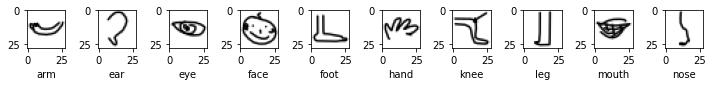

In [162]:
plt.figure(figsize=(10,10))
for i in range(len(body_parts)):
    plt.subplot(1,10,i+1)
    plt.xlabel(body_parts[i])
    plt.imshow(X_train[y_train.tolist().index(i)], cmap=plt.cm.binary)
plt.tight_layout()
plt.show()


2. plot the first 25 images in a 5x5 plot. Label the images.

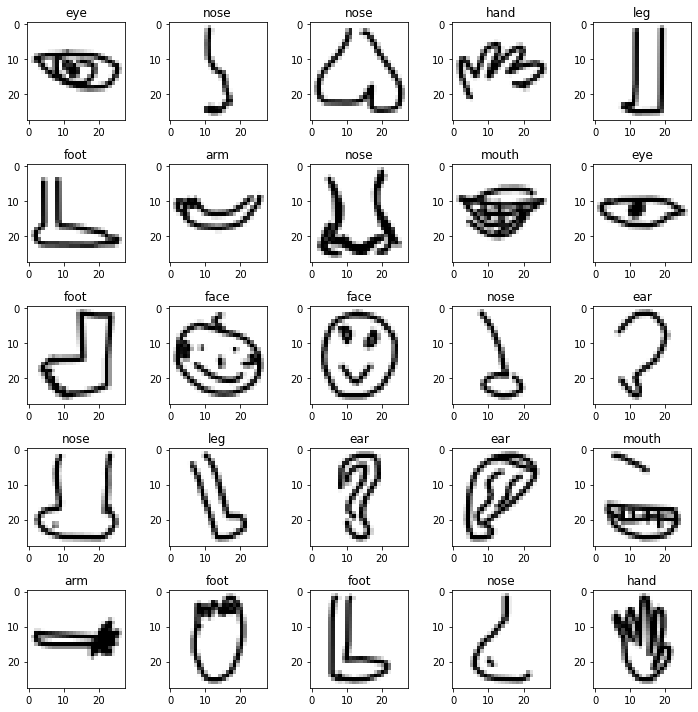

In [161]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.imshow(X_train[i], cmap=plt.cm.binary)
    plt.title(class_names[int(y_train[i])])
plt.tight_layout()
plt.show()


#### 2 Apply different kernels to an image of type face (1 mark)

1. pick an image of the face type and save it to `myface`. Plot it with `imshow` (nothing fancy needed for the plot)

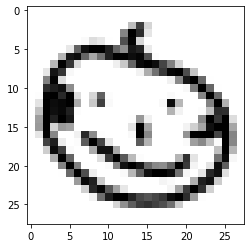

In [12]:
myface = X_train[y_train.tolist().index(3)]
plt.imshow(myface,cmap=plt.cm.binary)

2. Define 4 kernels: identity, edge_detection, sharpening, and blurring, as `3x3` numpy arrays. We add them to a dictionary of kernels.

In [165]:
#3,3,1 for 3rd dimension

k_identity = np.zeros((3,3,1))
k_identity[1,1] = 1

k_edge = -1*np.ones((3,3,1))
k_edge[1,1,0] = 8

k_sharp= np.array([[[0],[-1],[0]],[[-1],[5],[-1]],[[0],[-1],[0]]])

k_blur = np.ones((3,3,1))/9

kernels = {"identity":k_identity,"edge":k_edge,"sharp":k_sharp,"blur":k_blur}

3. Given is part of the `run_kernel` function which runs over the figure and applies the kernel to every non-edge pixel. Complete the function:
    - Define the shape of the output image `np.empty(...)`
    - Define the ranges of the row and colum loops , i.e. `range(...)`
    - Define the fig index on which the kernel is multiplied in each step, ie. `fig[....]`



In [53]:
def run_kernel(fig,kernel):
    #empty array holding the output image. Define the output dimensions as excercise.
    redx =fig.shape[0]-2 #non edge so x&y dimensions reduce by 2
    redy = fig.shape[1]-2
    out = np.empty((redx,redy,1)) 
    for i in range(redx):
        for j in range(redy):
            out[i][j] = np.sum(np.multiply(kernel,fig[i:i+kernel.shape[0],j:j+kernel.shape[1]]))
                
    return out

4. run the plotting code block below and check that the kernels are doing what you expect.
    
Since some kernels multiply by negatives, we use the norm=norm(0,1) to scale the image back to between 0 and 1 before plotting. 

In [54]:
#Import the normiliser for the bitmap
from matplotlib.colors import Normalize as norm

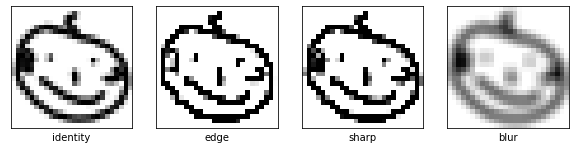

In [55]:
plt.figure(figsize=(10,10))
#Loop over kernel
for i,kernel in enumerate(kernels):
    plt.subplot(1,4,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    #return transformed image and plot it
    plt.imshow(run_kernel(myface,kernels[kernel]),cmap=plt.cm.binary,norm=norm(0,1))  
    plt.xlabel(kernel)
plt.show()



## Image classification (3.5 mark)
---
In this section, we will train a convolutional neural network (CNN) to perform hand-written digit recognition; a standard form of image classification. We will:
- create the model
- train the model
- evaluate its classification performance

#### 3. Define a Convolutional Neural Network suitable for image classification (1 mark).

* Use the **`Keras` functional API** to construct the model. 
* The shape of the input layer should match the shape of the prepared images.
* Add some **convolutional** and **pooling** layers in a sensible configuration. The architecture is a bit up to you, but try to reach a good level of accuracy. Around 85% on validation seems easily achievable.
    * By default, you can use $3 \times 3$ kernels, ReLU activation, and $2\times 2$ pooling; but feel free to play around with different values.
    * By default no padding is applied. You could try "same" padding in order to use the whole image, though results don't change much for me.
    * If sufferening from large overtraining could try regularisation: `kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4)`
   
* **Flatten** the output of the last convolutional layer.
* Connect it, to an **output** layer with the appropriate number of nodes and choice of activation function.
* Display the model architecture using the `<model>.summary()` method. Optionally display it also with the `plot_model(<model>, show_shapes=True)` method.  
* Questions:
    * _What are the number of trainable parameters in the model?_
    * _How many trainable parameters does your first convolutional layer have? Why?_
    * _Which layer has the most trainable parameters?_

In [56]:
inputs = Input(shape=shape)
conv1 = Conv2D(8, kernel_size = (3,3), activation='relu',padding='same',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(inputs)
pool1 = MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = Conv2D(16, kernel_size = (3,3), activation='relu',padding='same',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool1)
pool2 = MaxPooling2D(pool_size=(2,2))(conv2)
conv3 = Conv2D(24, kernel_size = (3,3), activation='relu',padding='same',kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4))(pool2)
pool3 = MaxPooling2D(pool_size=(2,2))(conv3)
flat = Flatten()(pool3)
hidden = Dense(20, activation = 'relu')(flat) 
output = Dense(nb_classes,activation='softmax')(hidden)
mdl = Model(inputs,output)

mdl.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 14, 14, 8)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 16)        1168      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 7, 7, 16)          0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 7, 7, 24)          3480      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 3, 3, 24)          0   

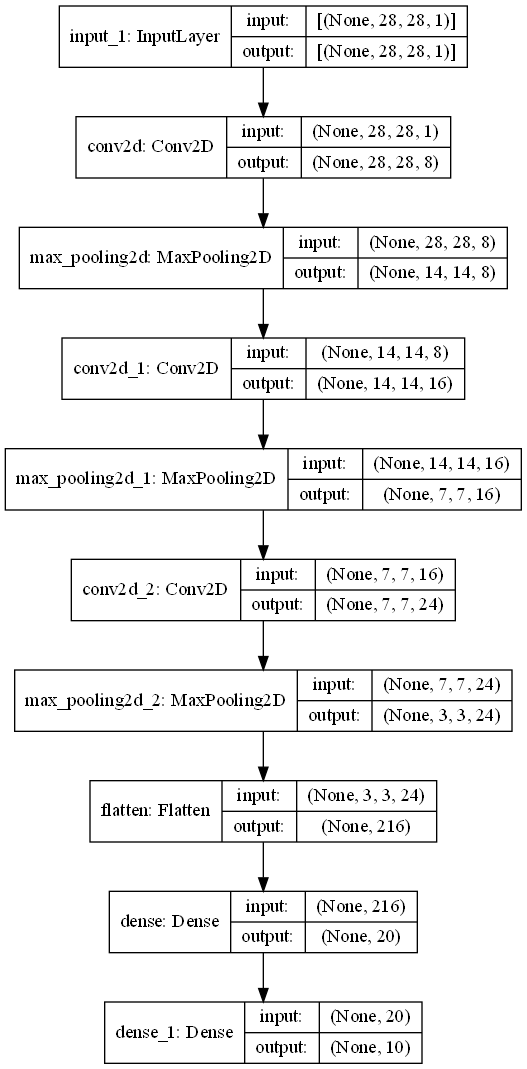

In [18]:
plot_model(mdl, show_shapes=True)

#questions:
What are the number of trainable parameters in the model?
there are 9278 trainable parameters in this model


How many trainable parameters does your first convolutional layer have? Why?
the first convolutional layer has 80 trainable parameters as it maps to 8 different kernels. each kernel is 3,3,1 in shape so (3*3*1 +1(for bias node))*8=80 

Which layer has the most trainable parameters?
the first dense layer has the most (4340)~ trainable parameters

#### 4. Compile and train the CNN image classifier (1 mark)

* Choose the appropriate loss functiton. 
* Fit for a reasonable number of epochs, use 20% of data for validation. 
* Plot the loss curve(s) by using `matplotlib.pyplot` directly with the information in the `<model>.history.history` dict.
* If you run on CPUs, stretch your legs while you wait for the 20 epoches to complete. Now is a good time for a coffee/loo break!

In [59]:
mdl.compile('adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])

cnn = mdl.fit(X_train,y_train,epochs=20,batch_size=32, validation_split=0.2)

Train on 128000 samples, validate on 32000 samples
Epoch 1/20
128000/128000 [==============================] - 52s 405us/sample - loss: 0.7982 - acc: 0.7485 - val_loss: 0.6380 - val_acc: 0.8018
Epoch 2/20
128000/128000 [==============================] - 46s 356us/sample - loss: 0.5845 - acc: 0.8189 - val_loss: 0.5617 - val_acc: 0.8265
Epoch 3/20
128000/128000 [==============================] - 48s 378us/sample - loss: 0.5346 - acc: 0.8343 - val_loss: 0.5281 - val_acc: 0.8344
Epoch 4/20
128000/128000 [==============================] - 51s 401us/sample - loss: 0.5063 - acc: 0.8429 - val_loss: 0.5132 - val_acc: 0.8405
Epoch 5/20
128000/128000 [==============================] - 51s 395us/sample - loss: 0.4883 - acc: 0.8477 - val_loss: 0.5033 - val_acc: 0.8438
Epoch 6/20
128000/128000 [==============================] - 47s 371us/sample - loss: 0.4732 - acc: 0.8527 - val_loss: 0.4967 - val_acc: 0.8455
Epoch 7/20
128000/128000 [==============================] - 46s 360us/sample - loss: 0.4623

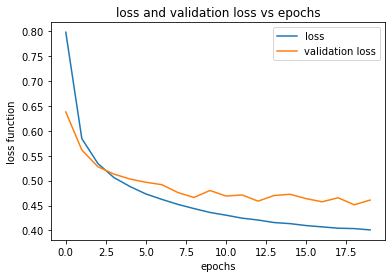

In [60]:
#plot
plt.plot(cnn.history['loss'],label="loss")
plt.plot(cnn.history['val_loss'],label="validation loss")
plt.title('loss and validation loss vs epochs')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend()
plt.show()


#### 5. Evaluate the classification performance on the testing dataset (1 Mark)

* Compute the testing accuracy, _e.g._ using the `<model>.evaluate()` method. Compare to the training accuracy; can be read off from fit printout, if you added the `'accuracy'` metric, or can be calculated here.
* Display a few mis-classified images from the test dataset.
    * For this you will need to use the model to predict from the testing features.
    * This yields arrays of 10 probabilities, 1 per class. Get the index from maximum probability to find the class prediction. Maybe consider using `argmax`?
* Compute and display the confusion matrix (normalise by truth label). Discuss the results.

In [62]:
misc,testacc = mdl.evaluate(X_test,y_test)
misc,trainacc = mdl.evaluate(X_train,y_train)

print("Overall accuracy for training dataset: "+ str(trainacc*100) +"%")
print("Overall accuracy for testing dataset: "+ str(testacc*100) + "%")


160000/160000 [==============================] - 35s 222us/sample - loss: 0.4085 - acc: 0.8736
Overall accuracy for training dataset: 87.35812306404114%
Overall accuracy for testing dataset: 85.72999835014343%


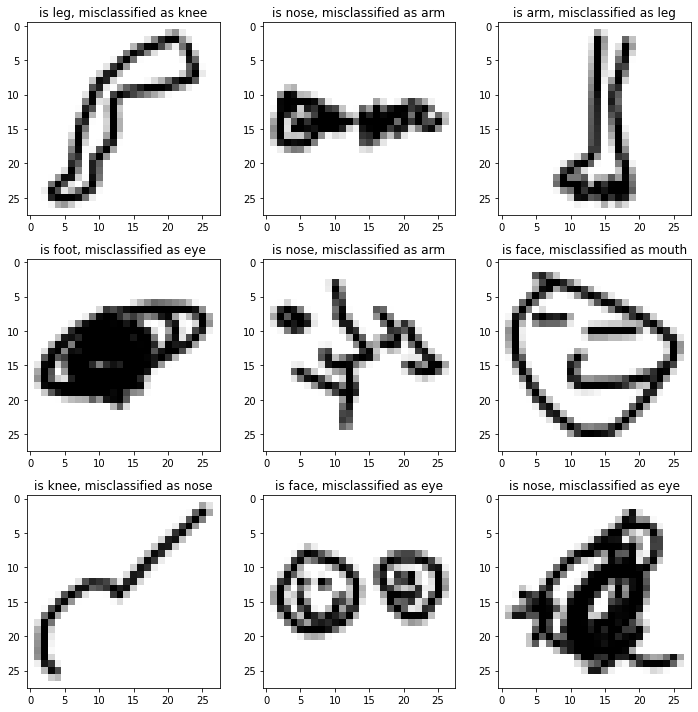

In [166]:
#misclassified
predictions = mdl.predict(X_test)
misclass = np.where(np.argmax(predictions, axis=-1)!=y_test)[0] #misclassified indexes

plt.figure(figsize=(10,10))
for i in range (9):
    plt.subplot(3,3,i+1)
    description=("is "+str(body_parts[int(y_test[misclass[i]])])+", misclassified as "+str(body_parts[np.argmax(predictions[misclass[i]])])) 
    plt.title(description)
    plt.imshow(X_test[misclass[i]],cmap=plt.cm.binary)
plt.tight_layout()
plt.show()

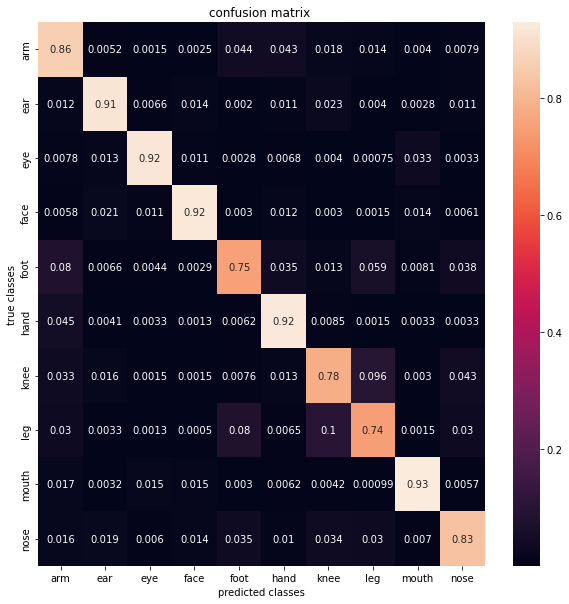

In [66]:
#confusion
cm = confusion_matrix(y_test, predictions.argmax(axis=-1), normalize='true')


fig, ax = plt.subplots(figsize=(10, 10))
sns.heatmap(cm,annot=True)
ax.set_yticklabels(body_parts)
ax.set_xticklabels(body_parts)
plt.xlabel("predicted classes")
plt.ylabel("true classes")
plt.title('confusion matrix ')
plt.show()


#discuss
the training accuracy is slightly (just under 2%) higher than the testing accuracy - this means the model is preforming well and not overfitting the training data. however, when tried without kernel_regularizer=regularizers.l1_l2(l1=1e-5, l2=1e-4) the model did not perform as well.

the confusion matrix shows the model generally classifies correctly due to the significant colour difference along the diagonal true labels. however, there seems to be slighltly less accuracy with classifying legs and feet correctly (almong with nose and arms but this is not as significant) compared to the other body parts which have ~90%+ accuracy

## Auto-encoders (3 marks)
---
In this section, we will construct and train an auto-encoder as an example of **unsupervised learning.** This type of model is made up of an **encoder** that maps an image of shape $(N,M,C)$ into a latent vector of shape $(L,)$; and a **decoder** which maps the latent vector into an image with the same shape as the original. The latent, or encoded, vector will typically be small in size compared to the input image (_i.e._ $L \ll N \times M \times C$), meaning that it is an **information bottleneck.** The aim of the auto-encoder is therefore to learn the most efficient encoding of a class of images (here: quickdraw dataset) that allows the decoder to reconstruct the original as well as possible under the bottleneck constraint.

We will break down this task into a few sub-tasks, to make it easier to get through.

#### 6. Construct the encoder (1 Marks)

* Use the `Keras` functional API to construct the encoder model. 
* The shape of the input layer should match the shape of the prepared images .
* Add some convolutional and pooling layers in a sensible configuration. 
    * Using a decreasing number of kernels for each convolutional layer (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) works quite well.
    * For this task it is worthwhile to give some thought to padding: You want to have intermediate layers with shapes that are easy to reconstruct with the decoder. As a starting point, consider using `padding='same'` for your conv. layers.
    * **See also the note below.**
* **Flatten** the output of the last convolutional layer, and use this as the latent vector. 
    * For convenience, we choose to make the latent vector have values in the range [0,1], so add the appropriate activation function to the preceeding convolutional layer.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * These methods are also very useful for debugging, when you are building your network. For instance, start with the simplest possible `Keras` model; plot the architecture using one of these methods; modify the model slightly; plot the architecture again to see the effect; _etc._
    * Make sure that the output of the encoder is indeed a bottleneck, _i.e._ that the number of output nodes is significantly smaller than the number of pixels in the image. (_Hint: A latent vector could have size $49 \ll 28 \times 28 \times 1 = 784$._)
    
**Note:** Choosing the architecture for an auto-encoder can be a bit tricky. The input images we use have shape $(28,28,1)$, and when we're pooling we typically downsample by a factor of $2$. If we use "same" padding, this means that we can go down to $(7,7,F)$ with no issues. However, if we downsample further (_e.g._ $7\to 3$) it will be tricky for the decoder to reconstruct, since upsampling would result in $3\to 6$. Therefore, to keep things simple, it may be best to not downsample further than $(7,7,F)$. However, you can still add _multiple convolutional layers in a row without pooling._

In [68]:
einput = Input(shape=shape)
econv1 = Conv2D(16, kernel_size = (3,3), activation='relu', padding='same')(einput)
epool1 = MaxPooling2D(pool_size=(2,2))(econv1)
econv2 = Conv2D(8, kernel_size = (3,3), activation='relu', padding='same')(epool1)
epool2 = MaxPooling2D(pool_size=(2,2))(econv2)
econv3 = Conv2D(4, kernel_size = (3,3), activation='relu', padding='same')(epool2)
econv4 = Conv2D(2, kernel_size = (3,3), activation='relu', padding='same')(econv3)
econv5 = Conv2D(1, kernel_size = (3,3), activation='relu', padding='same')(econv4)
flat = Flatten()(econv5)


encoder = Model(inputs=einput, outputs=flat)
encoder.summary()


Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 14, 14, 8)         1160      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 7, 7, 8)           0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 7, 7, 4)           292       
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 7, 7, 2)           74  

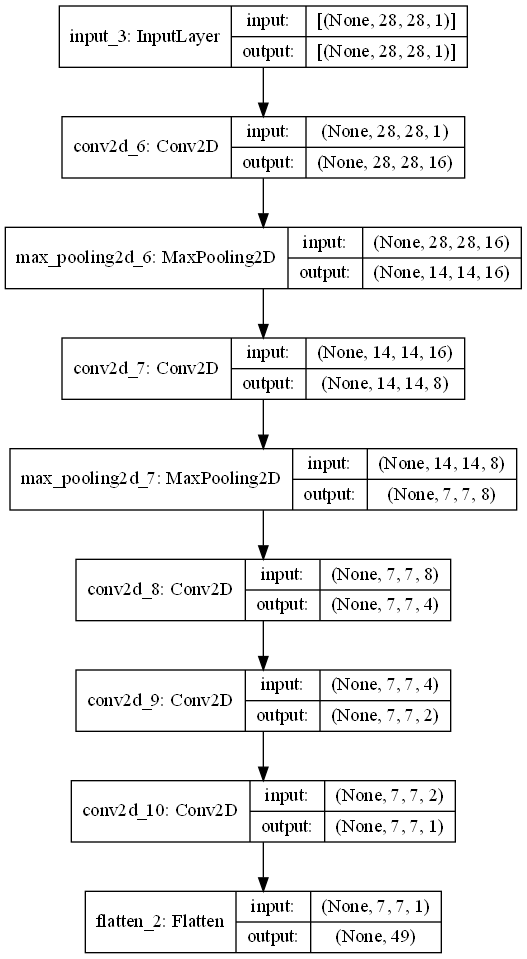

In [69]:
plot_model(encoder, show_shapes=True)

#### 7. Construct the decoder (1 Mark)

* Use the `Keras` functional API to construct the decoder model. 
* **Reshape** the latent vector to have the shape of the last convolutional layer in the encoder.
* The shape of the input layer should match the shape of the latent vector.
* Add some convolutional and **upsampling** layers in a sensible configuration. 
    * You can use the same order of kernels (_e.g._ $16 \to 8 \to 4 \to 2 \to 1$) as in the encoder.
    * Many of the notes and considerations mentioned for the encoder hold for the decoder as well.
* The output of the decoder should have the same shape as the number images. Also, choose an output activation that is appropriate to the dataset.
* Display the model architecture using the `<model>.summary()` method, optionally also the `plot_model(<model>, show_shapes=True)` method.
    * As for the encoder, these methods can be very useful for debugging.

In [70]:
#reshape
lastconv = (encoder.layers[-2].output_shape[1:]) # (7,7,1)
dinput = Input(shape=(np.prod(lastconv),)) #(49,)
shape = Reshape(lastconv)(dinput)
dconv1 = Conv2D(16, kernel_size = (3,3), activation='relu',padding='same')(shape)
dup1 = UpSampling2D((2,2))(dconv1)
dconv2 = Conv2D(8, kernel_size = (3,3), activation='relu',padding='same')(dup1)
dup2 = UpSampling2D((2,2))(dconv2)
dconv3 = Conv2D(4, kernel_size = (3,3), activation='relu',padding='same')(dup2)
dconv4 = Conv2D(2, kernel_size = (3,3), activation='relu',padding='same')(dconv3)
dconv5= Conv2D(1, kernel_size = (3,3), activation='sigmoid',padding='same')(dconv4)

decoder = Model(inputs=dinput, outputs=dconv5)
decoder.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 49)]              0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 1)           0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 7, 7, 16)          160       
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 14, 14, 8)         1160      
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 28, 28, 8)         0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 28, 28, 4)         292 

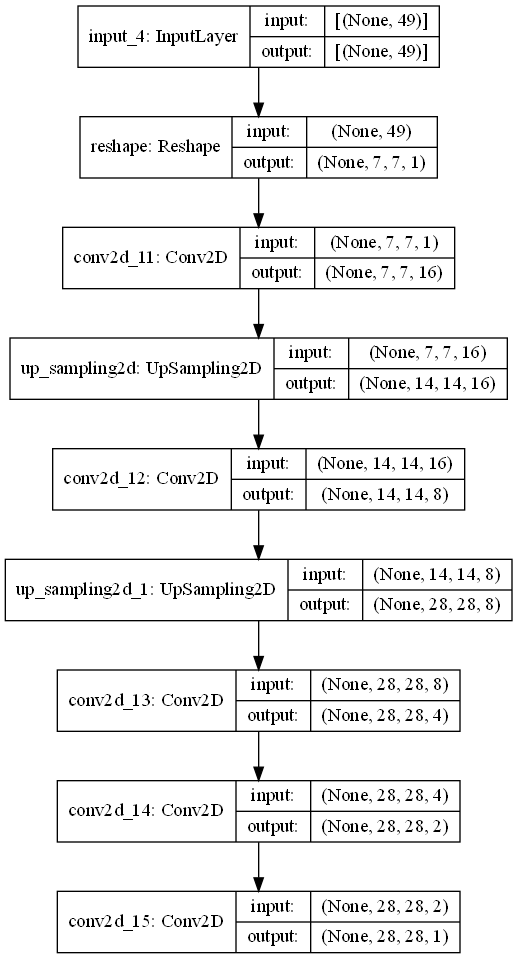

In [71]:
plot_model(decoder, show_shapes=True)

#### 8. Construct the auto-encoder (given, not marked)

Connecting the encoder and decoder to form the auto-encoder is a slightly tricky use of the `Keras` functional API, so I'll just give that to you. Assuming you have given you encoder and decoder intuitive names, the following should do the trick:

In [72]:
i   = encoder.input
cae = Model(i, decoder(encoder(i)), name='ConvAE')
cae.summary()

Model: "ConvAE"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
model_2 (Model)              (None, 49)                1705      
_________________________________________________________________
model_3 (Model)              (None, 28, 28, 1)         1705      
Total params: 3,410
Trainable params: 3,410
Non-trainable params: 0
_________________________________________________________________


Try to make sure that you understand what is going on here: In the `Keras` functional API, layers and even entire models work like functions (thus the name). What we're doing above is passing an input image `i` through the encoder (resulting in a latent vector); passing the output of `encoder` as the input to `decoder` (resulting in a reconstructed image); and finally using the output of `decoder` as the output of the auto-encoder.

#### 9. Compile and train the auto-encoder (1 Mark)

* Choose an appropriate loss function.
* Train for ca. 10 epochs with some data held out for validation. Time for another coffee break!
* Plot the loss curve(s).
* Perform the auto-encoding for the testing images (use the `<model>.predict()` method) and display the first couple of _(a)_ original and _(b)_ auto-encoded images to see whether the outputs resembles the original images.

In [73]:
cae.compile('adam', loss='binary_crossentropy',metrics=['accuracy'])
history_cae = cae.fit(x=X_train, y=X_train, epochs=10, validation_split=0.2, batch_size=32)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Train on 128000 samples, validate on 32000 samples
Epoch 1/10
128000/128000 [==============================] - 226s 2ms/sample - loss: 0.1924 - acc: 0.7708 - val_loss: 0.1607 - val_acc: 0.7793
Epoch 2/10
128000/128000 [==============================] - 235s 2ms/sample - loss: 0.1570 - acc: 0.7803 - val_loss: 0.1537 - val_acc: 0.7808
Epoch 3/10
128000/128000 [==============================] - 210s 2ms/sample - loss: 0.1523 - acc: 0.7813 - val_loss: 0.1504 - val_acc: 0.7816
Epoch 4/10
128000/128000 [==============================] - 218s 2ms/sample - loss: 0.1498 - acc: 0.7818 - val_loss: 0.1489 - val_acc: 0.7819
Epoch 5/10
128000/128000 [==============================] - 228s 2ms/sample - loss: 0.1484 - acc: 0.7820 - val_loss: 0.1476 - val_acc: 0.7822
Epoch 6/10
128000/128000 [==============================] - 197s 2ms/sample - loss: 0.1476 - acc: 0.7821 - val_loss: 0.1470 - val_acc: 0.7823
Epo

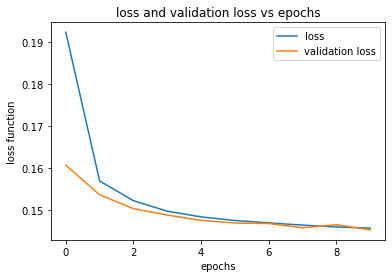

In [77]:
#plot
plt.plot(history_cae.history['loss'],label="loss")
plt.plot(history_cae.history['val_loss'],label="validation loss")
plt.title('loss and validation loss vs epochs')
plt.ylabel('loss function')
plt.xlabel('epochs')
plt.legend()
plt.show()

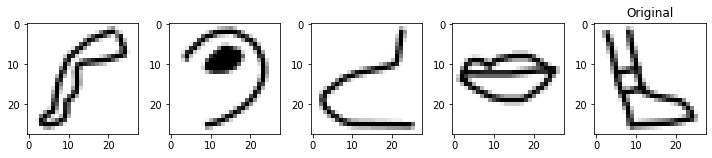

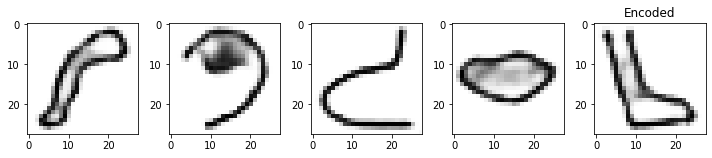

In [159]:
#display
predictedim = cae.predict(X_test)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(X_test[i],cmap=plt.cm.binary)
plt.title('Original')
plt.tight_layout()
plt.show()  

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(predictedim[i],cmap=plt.cm.binary)
plt.title('Encoded')
plt.tight_layout()
plt.show()


#### 10. Plot images in the laten space
- Predict 10 images into the laten space using the encoder only.
- Reshape the output to images and plot the laten space images. e.g. if your encoder outputs 49 features, make 7x7 image

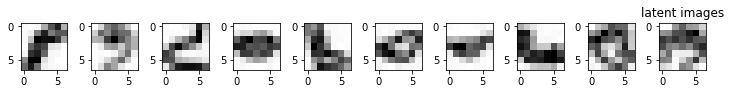

In [158]:
#just use encoder
latentimages = encoder.predict(X_test)

plt.figure(figsize=(10, 10))
for i in range (10):
    ax = plt.subplot(1, 10, i+1)
    plt.imshow(np.reshape(latentimages[i],(7,7,1)),cmap=plt.cm.binary)
plt.title("latent images")
plt.tight_layout()
plt.show()


## Anomaly detection (2 marks)
---

We have introduced auto-encoders as a form of unsupervised learning, since we are not using the image labels during training. This means that auto-encoders are not ideal for image classification (at least not since we actually _have_ the labels), but they can be used for something else: anomaly detection. This is the task of identifying examples that the model considers "anomalous" with respect to the dataset used during training. 

First, we'll load in some "anomalous" data:

In [90]:
from sklearn.datasets import fetch_olivetti_faces
faces = fetch_olivetti_faces(shuffle=True)['images']
faces = faces[:,4:-4:2,4:-4:2,np.newaxis]

#### 9. Inspect the face images and the auto-encoder result (1 mark)

* How many samples does the "outlier" dataset (_i.e._ `faces`) contain?
* What is the shape of the images and what is the range of pixel intensities? Does this conform with the preprocessed quickdraw images?
* Display the first few face images.
* Get the output/prediction of the auto-encoder from the previous section when applied to all of the faces.
* Show the auto-encoded versions of the same faces you showed above. Discuss the results.

In [91]:
# samples in faces
print(len(faces))

400


In [92]:
#shapes
print(np.shape(faces[0]))

(28, 28, 1)


In [93]:
#pixel intensity
print("maximum: " + str(np.max(faces)))
print("minimum: " + str(np.min(faces)))

maximum: 0.9710744
minimum: 0.020661157


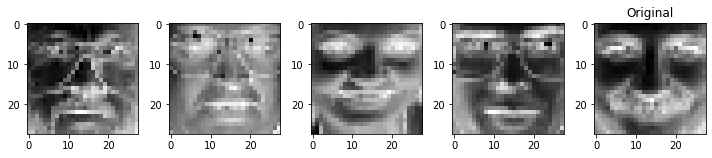

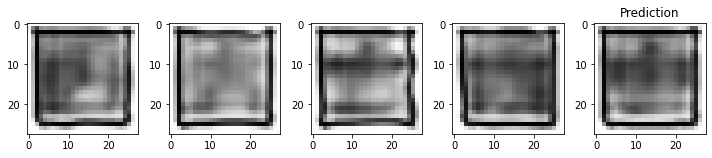

In [157]:
predictedface = cae.predict(faces)

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(faces[i],cmap=plt.cm.binary)
plt.title('Original')
plt.tight_layout()
plt.show()  

plt.figure(figsize=(10,10))
for i in range(5):
    plt.subplot(1,5,i+1)
    plt.imshow(predictedface[i],cmap=plt.cm.binary)
plt.title('Prediction')
plt.tight_layout()
plt.show()

already an answer here for the discuss part?

_Indicative answers:_
    
* The face images have the same shape and pixel intensity range as the preprocessed quickdraw images, so they are valid inputs to the auto-encoder.
* We can see that the auto-encoder transformed faces are _very_ unlike the input images. This is because the auto-encoder was trained to learn an efficient representation of hand-written digits which is not necessarily an efficient representation for other image domains, _e.g._ faces. This examples shows that this is clearly the case. From the point of view of the auto-encoder, images of faces are _anomalies_ in that they are fundamentally unlike the images on which it was trained, and therefore we shouldn't expect it to do a good job in encoding them.

#### 11. Perform anomaly detection (1 mark)
Imagine now that we had a dataset comprised of mostly quickdraw images, but also a small subset of anomalies or "outliers"; here, in the form of black-and-white images of faceses, with the same shape as the quickdraw images.

In [97]:
# Combined MNIST images and "outliers" in a mixed dataset
mixed = np.vstack((X_test, faces))

# Shuffle the mixed dataset so the "outliers" are randomly distributed
indices = np.random.permutation(mixed.shape[0])
mixed   = mixed[indices]

The auto-encoder was trained to minimise the difference between the original and the auto-encoded image, so let's use binary cross-entropy (BCE) as our metric for the difference between an image and its auto-encoded version. The `binary_crossentropy` method provided below computes **pixel-wise BCE** for two (arrays of) images: the input and the output image.

In [98]:
def binary_crossentropy (img_in, img_out):
    assert img_in.shape == img_out.shape
    eps = np.finfo(float).eps
    img_out = np.clip(img_out, eps, 1. - eps)
    return - (img_in * np.log(img_out) + (1 - img_in) * np.log(1 - img_out))

---
* Define a new method called `difference` which takes as input two arrays of images (`img_in` and `img_out`; similar to the `binary_crossentropy`); computes the **average BCE value for each image,** or row; and returns a vector of these difference measures.
* For each image, or row, in `mixed`, compute the difference score of the auto-encoded image wrt. the original image. This is a measure of how "inlier"- or "outlier"-like an image is.
* Make a histogram of these scores, and see if you can identify any structure. It might be useful to use a logarithmic x-axis (see `plt.xscale`) along with logarithmic x-axis bins (see `np.logspace`).
* Show the 9 least and the 9 most outlying images, according to this difference score. Discuss the results.

In [100]:
def difference(img_in,img_out):
    bce1 = np.mean(binary_crossentropy(img_in,img_in))
    bce2 = np.mean(binary_crossentropy(img_out,img_out))
    return bce2-bce1

mixpred = cae.predict(mixed)
diflist =[]
for i in range (len(mixed)):
    diflist.append(difference(mixed[i],mixpred[i]))

Text(0.5, 0, 'Differences')

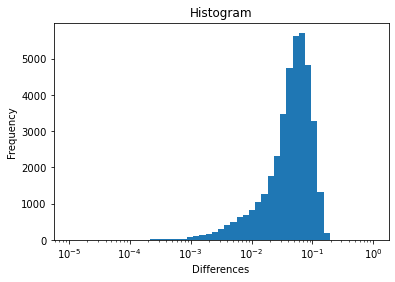

In [102]:
#plot
plt.hist(diflist, bins=np.logspace(-5,0))
plt.xscale("log")
plt.title("Histogram")
plt.xlabel("Differences")
plt.ylabel("Frequency")


[6.00950727e-06 7.56229688e-06 9.41675622e-06 9.52974946e-06
 1.04693401e-05 1.73849786e-05 2.25195161e-05 2.29894254e-05
 2.96218120e-05]
[0.2067195  0.21069884 0.21206473 0.2121462  0.21573568 0.22637601
 0.23010777 0.23938089 0.27363561]


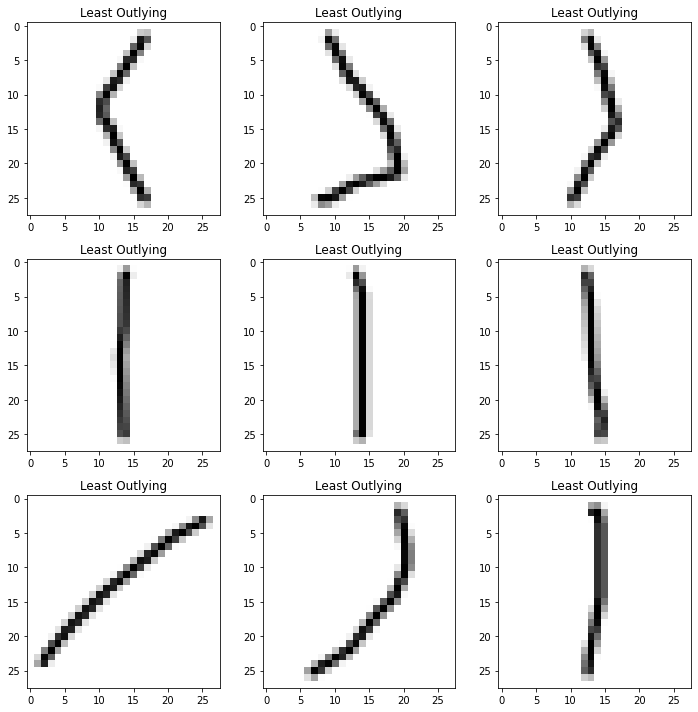

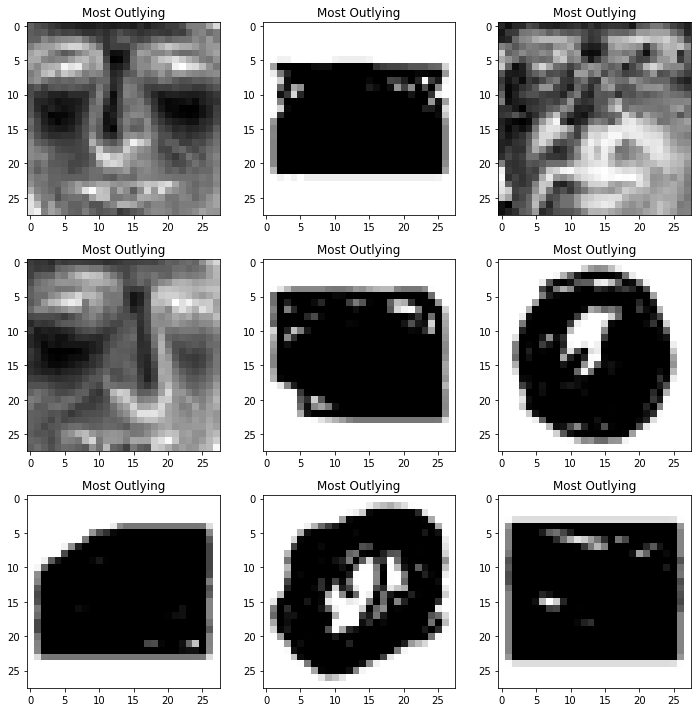

In [181]:
#9 least and 9 most
diflist = np.abs(diflist) #outliers can be on either side +/-
least= np.sort(diflist)[:9]
most= np.sort(diflist)[-9:]

print(least)
print(most)


plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    find = np.where(diflist==least[i])[0][0]
    plt.imshow(mixed[find],cmap=plt.cm.binary)
    plt.title('Least Outlying')
plt.tight_layout()
plt.show()  

plt.figure(figsize=(10,10))
for i in range(9):
    plt.subplot(3,3,i+1)
    find = np.where(diflist==most[i])[0][0]
    plt.imshow(mixed[find],cmap=plt.cm.binary)
    plt.title('Most Outlying')
plt.tight_layout()
plt.show()


#discuss)
we see that the least outlying images are all relitively simple lines so it easy for the autoencoder to encode them. the most outlying images are a mix of faces and unclear, heavily shaded line drawings - this is expeced as the autoencoder is trained on line drawings so naturally will have trouble classifying images of human faces and it is difficult to see what is drawn in the heavily shaded line drawings compares to the majority of the other body parts.
